# BigFeat Performance Testing

This notebook tests the `BigFeat` feature engineering tool on an extended set of datasets and models, comparing performance with and without BigFeat. The datasets include classification (Synthetic Classification, Breast Cancer, Iris, Digits, Wine, Covertype subset) and regression (Synthetic Regression, Diabetes, California Housing, Ames Housing, Friedman1, Friedman2) tasks. Models tested are RandomForest, LightGBM, and LogisticRegression (for classification) or LinearRegression (for regression). Performance is evaluated using F1-score (classification, weighted for multiclass) or R2-score (regression), and results are visualized in bar plots arranged in a grid layout.

**Note**: All inputs are converted to NumPy arrays to mitigate LightGBM feature name warnings, and `bigfeat_base.py` remains unchanged. The Ames Housing dataset replaces Boston Housing due to ethical concerns with the latter.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_regression, load_breast_cancer, load_diabetes, fetch_california_housing
from sklearn.datasets import load_iris, load_digits, load_wine, fetch_covtype, make_friedman1, make_friedman2
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
import matplotlib.pyplot as plt
from bigfeat.bigfeat_base import BigFeat  # Import from bigfeat directory

# Set random seed for reproducibility
np.random.seed(42)

## Load Datasets

Define an extended set of classification and regression datasets. Classification includes Synthetic Classification, Breast Cancer, Iris, Digits, Wine, and Covertype (subset). Regression includes Synthetic Regression, Diabetes, California Housing, Ames Housing (numerical features), Friedman1, and Friedman2. All data is converted to NumPy arrays to avoid feature name issues.

In [3]:
def load_datasets():
    # Classification datasets
    synth_clf = make_classification(n_samples=1000, n_features=20, n_informative=15, random_state=42)
    breast_cancer = load_breast_cancer()
    iris = load_iris()
    digits = load_digits()
    wine = load_wine()
    # Covertype is large, so use a subset (first 10,000 samples, binary classification)
    covtype = fetch_covtype()
    covtype_subset_idx = np.arange(10000)
    covtype_X = covtype.data[covtype_subset_idx]
    covtype_y = (covtype.target[covtype_subset_idx] == 1).astype(int)  # Binary: class 1 vs. others
    
    # Regression datasets
    synth_reg = make_regression(n_samples=1000, n_features=20, n_informative=15, random_state=42)
    diabetes = load_diabetes()
    california = fetch_california_housing()
    # Ames Housing dataset, using numerical features only
    ames = fetch_openml(name='house_prices', as_frame=True, version=1)
    ames_df = ames.frame
    # Select numerical columns and target (SalePrice)
    numerical_cols = ames_df.select_dtypes(include=['int64', 'float64']).columns
    numerical_cols = numerical_cols.drop('SalePrice')  # Exclude target
    ames_X = ames_df[numerical_cols].fillna(0).values  # Fill NaNs with 0
    ames_y = ames_df['SalePrice'].values
    friedman1 = make_friedman1(n_samples=1000, n_features=10, random_state=42)
    friedman2 = make_friedman2(n_samples=1000, random_state=42)
    
    datasets = {
        'classification': [
            ('Synthetic_Clf', np.array(synth_clf[0]), np.array(synth_clf[1])),
            ('Breast_Cancer', np.array(breast_cancer.data), np.array(breast_cancer.target)),
            ('Iris', np.array(iris.data), np.array(iris.target)),
            ('Digits', np.array(digits.data), np.array(digits.target)),
            ('Wine', np.array(wine.data), np.array(wine.target)),
            ('Covertype_Subset', np.array(covtype_X), np.array(covtype_y))
        ],
        'regression': [
            ('Synthetic_Reg', np.array(synth_reg[0]), np.array(synth_reg[1])),
            ('Diabetes', np.array(diabetes.data), np.array(diabetes.target)),
            ('California_Housing', np.array(california.data), np.array(california.target)),
            ('Ames_Housing', np.array(ames_X), np.array(ames_y)),
            ('Friedman1', np.array(friedman1[0]), np.array(friedman1[1])),
            ('Friedman2', np.array(friedman2[0]), np.array(friedman2[1]))
        ]
    }
    return datasets

## Define Models

Define models for classification (RandomForest, LightGBM, LogisticRegression) and regression (RandomForest, LightGBM, LinearRegression). Increase `max_iter` for LogisticRegression to prevent convergence warnings.

In [4]:
def get_models(task_type):
    if task_type == 'classification':
        return {
            'RandomForest': RandomForestClassifier(random_state=42),
            'LightGBM': LGBMClassifier(random_state=42),
            'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000)  # Increased max_iter
        }
    else:  # regression
        return {
            'RandomForest': RandomForestRegressor(random_state=42),
            'LightGBM': LGBMRegressor(random_state=42),
            'LinearRegression': LinearRegression()
        }

## Evaluate Models

Function to evaluate model performance using F1-score for classification (weighted for multiclass) or R2-score for regression. Convert inputs to NumPy arrays to avoid LightGBM feature name warnings.

In [5]:
def evaluate_model(model, X_train, X_test, y_train, y_test, task_type):
    # Convert inputs to NumPy arrays to avoid LightGBM feature name warnings
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # Apply scaling for LogisticRegression to improve convergence
    if isinstance(model, LogisticRegression):
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if task_type == 'classification':
        # Use weighted F1-score for multiclass datasets (e.g., Iris, Digits, Wine)
        return f1_score(y_test, y_pred, average='weighted')
    else:  # regression
        return r2_score(y_test, y_pred)

## Test BigFeat

Test `BigFeat` on all datasets and models, comparing performance with and without BigFeat. Ensure inputs are NumPy arrays.

In [6]:
def test_bigfeat():
    datasets = load_datasets()
    results = {'classification': {}, 'regression': {}}
    
    for task_type in ['classification', 'regression']:
        bigfeat = BigFeat(task_type=task_type)
        models = get_models(task_type)
        
        for dataset_name, X, y in datasets[task_type]:
            # Ensure inputs are NumPy arrays
            X = np.array(X)
            y = np.array(y)
            
            # Split data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            # Fit and transform with BigFeat
            X_train_bf = bigfeat.fit(X_train, y_train, random_state=42)
            X_test_bf = bigfeat.transform(X_test)
            
            # Evaluate models
            results[task_type][dataset_name] = {}
            for model_name, model in models.items():
                # Performance with BigFeat
                score_bf = evaluate_model(model, X_train_bf, X_test_bf, y_train, y_test, task_type)
                # Performance without BigFeat
                score_orig = evaluate_model(model, X_train, X_test, y_train, y_test, task_type)
                results[task_type][dataset_name][model_name] = {'BigFeat': score_bf, 'Original': score_orig}
    
    return results

## Plot Results

Generate bar plots comparing BigFeat vs. original feature performance for each dataset and model, using a grid layout for better visualization. Plots are displayed and saved as PNG files.

In [7]:
def plot_results(results):
    for task_type in ['classification', 'regression']:
        n_datasets = len(results[task_type])
       
        n_rows = 2 if task_type == 'classification' else 3
        n_cols = (n_datasets + n_rows - 1) // n_rows
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4), sharey=True, squeeze=False)
        axes = axes.flatten()

        for idx, (dataset_name, model_results) in enumerate(results[task_type].items()):
            models = list(model_results.keys())
            bigfeat_scores = [model_results[m]['BigFeat'] for m in models]
            orig_scores = [model_results[m]['Original'] for m in models]

            x = np.arange(len(models))
            width = 0.35

            ax = axes[idx]
            ax.bar(x - width/2, bigfeat_scores, width, label='BigFeat', color='skyblue')
            ax.bar(x + width/2, orig_scores, width, label='Original', color='lightcoral')

            ax.set_title(dataset_name)
            ax.set_xticks(x)
            ax.set_xticklabels(models, rotation=45)
            ax.set_ylim(0, 1)
            ax.legend()
            if idx % n_cols == 0:
                ax.set_ylabel('F1 Score' if task_type == 'classification' else 'R2 Score')

        # Hide unused subplots
        for idx in range(len(results[task_type]), len(axes)):
            axes[idx].set_visible(False)

        plt.tight_layout()
        plt.savefig(f'{task_type}_performance.png')
        plt.show()

## Run Tests and Plot

Execute the tests and generate the plots.

In [8]:
results = test_bigfeat()

C:\Users\mohan\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\mohan\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\mohan\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\mohan\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\BigFeat\bigfeat\bigfeat_base.py:263: RuntimeWarning: invalid value encountered in divide
  lgb_imps /= lgb_imps.sum()
C:\Users\mohan\AppData\Roaming\

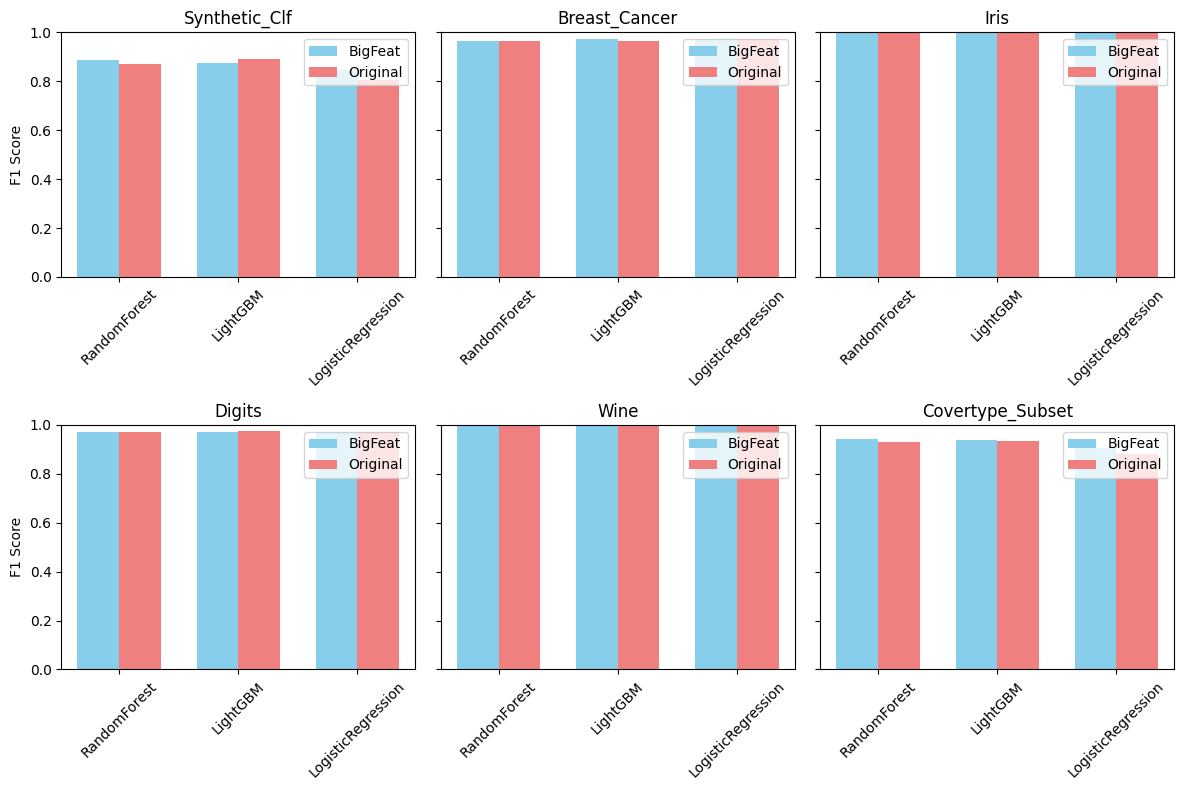

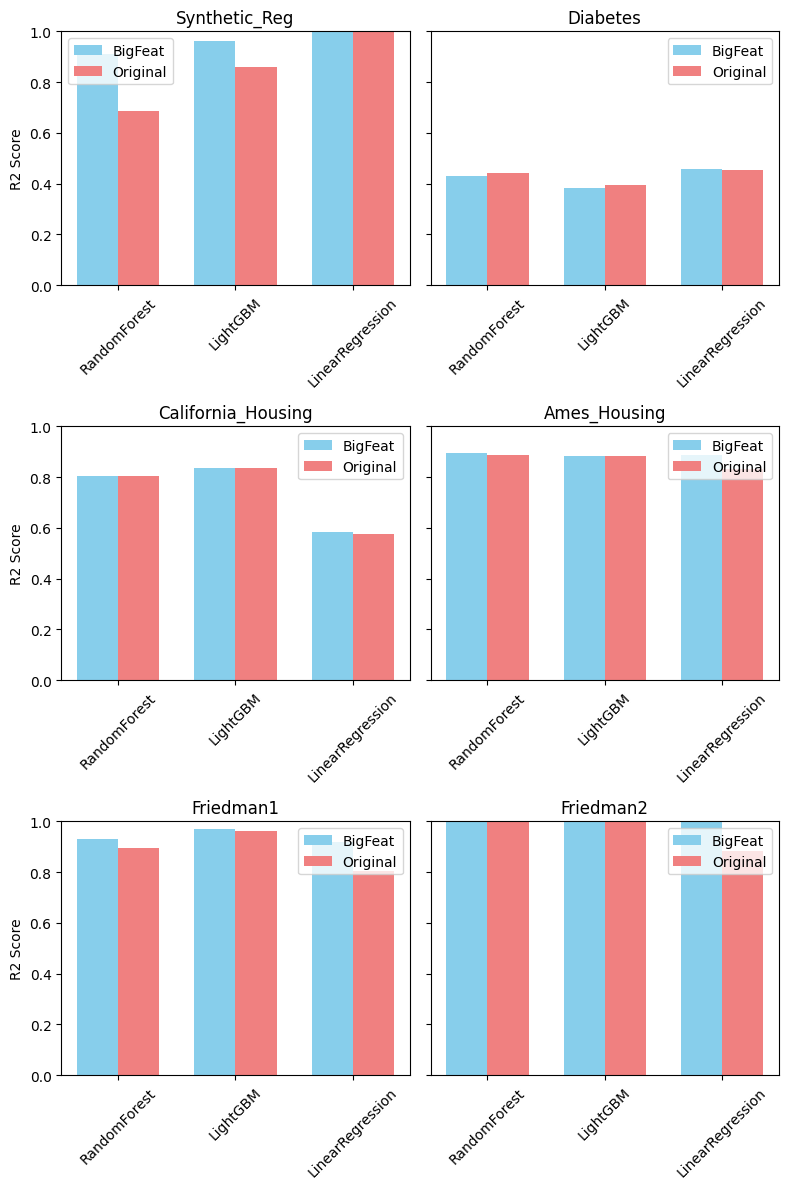

In [9]:
plot_results(results)